In [22]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset, SyntheticDatasetType
from HySpecLab.metrics import rmse, sad

# LMM and ELMM solution

In [23]:
exp_label = 'no-preprocessing/snr10'
dataset_type = SyntheticDatasetType.SNR10

result_path = os.path.join(config.RESULTS_PATH, 'syntheticData/matlab/{}'.format(exp_label))
dataset = SyntheticDataset(config.Synthetic_PATH, type=dataset_type)

In [24]:
from scipy import io as sio

endmember_estimation = sio.loadmat(os.path.join(result_path, 'endmember_estimation.mat'))
vca_ee = torch.tensor(endmember_estimation['VCA'])
nfindr_ee = torch.tensor(endmember_estimation['NFINDR'])

sad_result = sad(vca_ee, dataset.endmembers())
vca_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

sad_result = sad(nfindr_ee, dataset.endmembers())
nfindr_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

vca_ee = vca_ee[vca_idx]
nfindr_ee = nfindr_ee[nfindr_idx]

In [25]:
X_true = dataset.A @ dataset.E

In [26]:
input = sio.loadmat(os.path.join(result_path, 'input.mat'))
X = torch.tensor(input['X'].reshape(-1, input['X'].shape[-1], order='F'))

## Endmembers

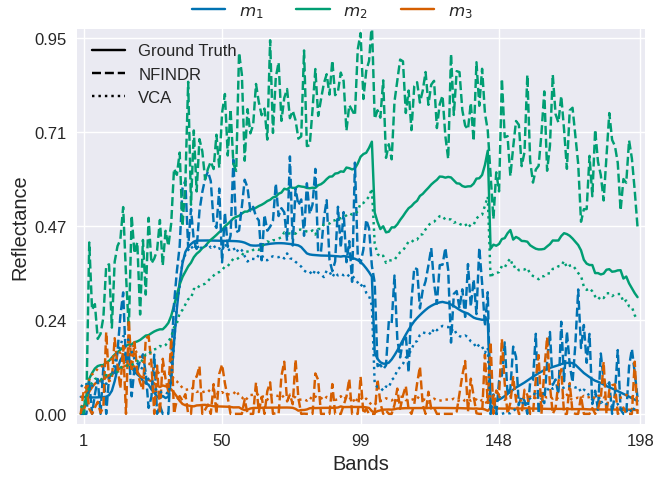

In [27]:
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, .95), 
                      endmember_estimation=[nfindr_ee, vca_ee],
                      ee_labels=['Ground Truth', 'NFINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/endmembers_estimation.pdf'), bbox_inches='tight')

In [28]:
from HySpecLab.metrics import sad

sad_result_vca = sad(vca_ee, dataset.endmembers())
print(sad_result_vca, np.diagonal(sad_result_vca.numpy()).mean())
sad_vca = np.diagonal(sad_result_vca.numpy()).mean()

sad_result_nfindr = sad(nfindr_ee, dataset.endmembers())
print(sad_result_nfindr, np.diagonal(sad_result_nfindr.numpy()).mean())
sad_nfindr = np.diagonal(sad_result_nfindr.numpy()).mean()

tensor([[0.1374, 0.5606, 1.0871],
        [0.4649, 0.0269, 1.1066],
        [0.9101, 0.8307, 0.3098]]) 0.15802276
tensor([[0.2064, 0.4834, 1.1414],
        [0.4960, 0.1617, 1.0224],
        [1.1257, 1.0333, 0.8422]]) 0.40340945


# Abundance

## LMM

In [37]:
FCLS = sio.loadmat(os.path.join(result_path, 'FCLS.mat'))
save_dir = os.path.join(result_path, 'imgs/LMM')

Xhat = FCLS['Xhat_NFINDR'].T

nfindr_reconstruct = torch.tensor(FCLS['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(FCLS['Xhat_VCA'].T)
nfindr_A = torch.tensor(FCLS['A_NFINDR'].T)
vca_A = torch.tensor(FCLS['A_VCA'].T)
# dataframe which contains the RMSE
# Saving metrics
import pandas as pd
lmm_df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
lmm_df['Method'] = ['LMM+NFINDR', 'LMM+VCA']
lmm_df['RMSE_X'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
lmm_df['RMSE_A'] = [rmse(dataset.A, nfindr_A, dim=None).numpy(), rmse(dataset.A, vca_A, dim=None).numpy()]
lmm_df['SAD_M'] = [sad_nfindr, sad_vca]
lmm_df

,Method,RMSE_X,RMSE_A,SAD_M
0,LMM+NFINDR,0.05830803,0.1588381336889531,0.403409
1,LMM+VCA,0.032635808,0.09235167203880593,0.158023


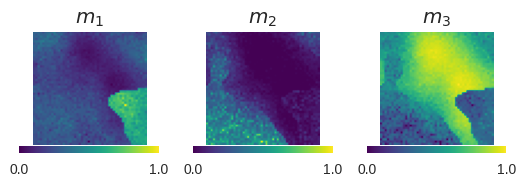

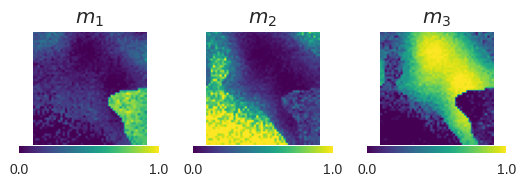

In [38]:
A = FCLS['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, nfindr_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.pdf'), dpi=300, bbox_inches='tight')

A = FCLS['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, vca_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.pdf'), dpi=300, bbox_inches='tight')

In [31]:
os.path.join(save_dir, 'A_VCA.pdf')

'/home/abian/Data/Thesis/CLHU/results/syntheticData/matlab/no-preprocessing/snr10/imgs/LMM/A_VCA.pdf'

## ELMM

In [32]:
ELMM = sio.loadmat(os.path.join(result_path, 'ELMM.mat'))
save_dir = os.path.join(result_path, 'imgs/ELMM')

from HySpecLab.metrics import rmse
nfindr_reconstruct = torch.tensor(ELMM['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(ELMM['Xhat_VCA'].T)
nfindr_A = torch.tensor(ELMM['A_NFINDR'].T)
vca_A = torch.tensor(ELMM['A_VCA'].T)

import pandas as pd
elmm_df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
elmm_df['Method'] = ['ELMM+NFINDR', 'ELMM+VCA']
elmm_df['RMSE_X'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
elmm_df['RMSE_A'] = [rmse(dataset.A, nfindr_A, dim=None).numpy(), rmse(dataset.A, vca_A, dim=None).numpy()]
elmm_df['SAD_M'] = [sad_nfindr, sad_vca]

elmm_df

,Method,RMSE_X,RMSE_A,SAD_M
0,ELMM+NFINDR,0.04861741835381816,0.10530354973297917,0.403409
1,ELMM+VCA,0.0466794936334714,0.14480586162464418,0.158023


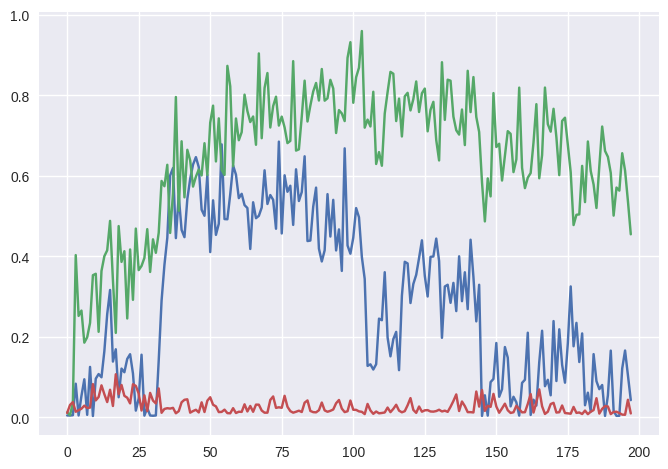

tensor([[0.1973, 0.4803, 1.1406],
        [0.4926, 0.1525, 1.0250],
        [0.8908, 0.7791, 0.6536]]) 0.33447704


In [33]:
M_test = ELMM['M_NFINDR'].mean(axis=2)
M_test.shape

plt.plot(M_test)
plt.show()

sad_test = sad(torch.tensor(M_test.T), dataset.endmembers())
print(sad_test, np.diagonal(sad_test.numpy()).mean())

In [34]:
nfindr_ee.shape

torch.Size([3, 198])

In [35]:
ELMM.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A_NFINDR', 'A_VCA', 'M_NFINDR', 'M_VCA', 'Xhat_NFINDR', 'Xhat_VCA'])

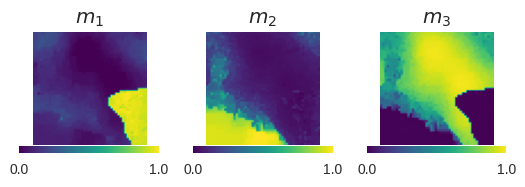

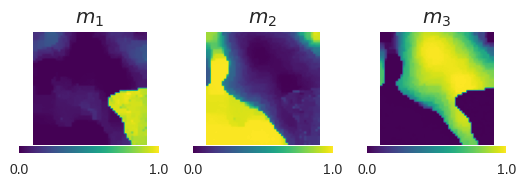

In [36]:
from utils import show_abundance
A = ELMM['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(np.abs(A[:, :, nfindr_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.pdf'), dpi=300, bbox_inches='tight')

A = ELMM['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(np.abs(A[:, :, vca_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.pdf'), dpi=300, bbox_inches='tight')

## Save dataframe

In [ ]:
df = pd.concat([lmm_df, elmm_df])
df.to_csv(os.path.join(result_path, 'metrics.csv'), index=False)
df